In [1]:
# === SETUP DEL ENTORNO ===

# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.svm import SVR
import warnings
import os
warnings.filterwarnings('ignore')

print("✅ Todas las librerías importadas correctamente")

# 3. Configurar visualizaciones
plt.style.use('seaborn-v0_8')  # estilo visual (ej: 'seaborn-v0_8', 'default', 'classic')
sns.set_palette("Set1")  # paleta de colores (ej: 'husl', 'Set1', 'viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("🎨 Configuración de visualizaciones lista!")

✅ Todas las librerías importadas correctamente
🎨 Configuración de visualizaciones lista!


In [2]:
# === CARGAR DATASET AMES HOUSING ===

# 1. Cargar dataset base
!curl -L -o ames-housing-dataset.zip https://www.kaggle.com/api/v1/datasets/download/shashanknecrothapa/ames-housing-dataset
!unzip ames-housing-dataset.zip
df = pd.read_csv('AmesHousing.csv')


print("🏠 DATASET: Ames Housing")
print(f"   📊 Forma original: {df.shape}")
print(f"   📋 Columnas: {list(df.columns)}")

# 2. Crear missing data sintético para práctica
np.random.seed(42)  # para reproducibilidad

# Simular MCAR en Year Built (8% missing aleatorio)
# "Los valores faltan al azar: que falte un Year Built no depende de la edad ni del propio Year Built"
missing_year = np.random.random(len(df)) < 0.08
df.loc[missing_year, 'Year Built'] = np.nan

# Simular MAR en Garage Area (missing relacionado con Garage Type)
# "Los faltantes de Garage Area se concentran en ciertos tipos de garaje (variable observada)"
df.loc[df['Garage Type'] == 'None', 'Garage Area'] = df.loc[df['Garage Type'] == 'None', 'Garage Area'].sample(frac=0.7, random_state=42)

# Simular MNAR en SalePrice (missing relacionado con precio alto)
# "Los faltantes dependen del propio valor: quienes tienen precios altos no reportan precio"
high_price = df['SalePrice'] > df['SalePrice'].quantile(0.85)
df.loc[high_price, 'SalePrice'] = df.loc[high_price, 'SalePrice'].sample(frac=0.2, random_state=42)

print("\n🔍 Missing data sintético creado:")
print(df.isnull().sum())  # método para contar valores faltantes por columna

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  184k  100  184k    0     0   183k      0  0:00:01  0:00:01 --:--:--  183k
Archive:  ames-housing-dataset.zip
  inflating: AmesHousing.csv         
🏠 DATASET: Ames Housing
   📊 Forma original: (2930, 82)
   📋 Columnas: ['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 

In [3]:
# === EXPLORACIÓN BÁSICA ===

# 1. Información general del dataset
print("=== INFORMACIÓN GENERAL ===")
print(df.info())  # método que muestra tipos de datos, memoria y valores no nulos

# 2. Estadísticas descriptivas
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
print(df.describe())  # método que calcula estadísticas descriptivas

# 3. Tipos de datos
print("\n=== TIPOS DE DATOS ===")
print(df.dtypes)  # atributo que muestra tipos de datos por columna

# 4. Verificar missing data
print("\n=== MISSING DATA POR COLUMNA ===")
missing_count = df.isnull().sum()  # contar valores faltantes
missing_pct = (missing_count / len(df)) * 100  # calcular porcentaje

missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': missing_count,
    'Missing_Percentage': missing_pct
})
print(missing_stats[missing_stats['Missing_Count'] > 0])

# 5. Análisis de memoria
print("\n=== ANÁLISIS DE MEMORIA ===")
total_bytes = df.memory_usage(deep=True).sum()  # método para memoria en bytes
print(f"Memoria total del DataFrame: {total_bytes / (1024**2):.2f} MB")
print(f"Memoria por columna:")
for col in df.columns:
    memory_usage = df[col].memory_usage(deep=True)  # método para memoria de una columna
    print(f"  {col}: {memory_usage / 1024:.2f} KB")

# 6. Análisis de duplicados
print("\n=== ANÁLISIS DE DUPLICADOS ===")
duplicates = df.duplicated()  # método para detectar filas duplicadas
print(f"Número de filas duplicadas: {duplicates.sum()}")
if duplicates.sum() > 0:
    print("Primeras 5 filas duplicadas:")
    print(df[df.filter()].head())  # método para filtrar duplicados

=== INFORMACIÓN GENERAL ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null  

Columnas con missing data: 29
Columnas: ['Lot Frontage', 'Alley', 'Year Built', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Electrical', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature', 'SalePrice']


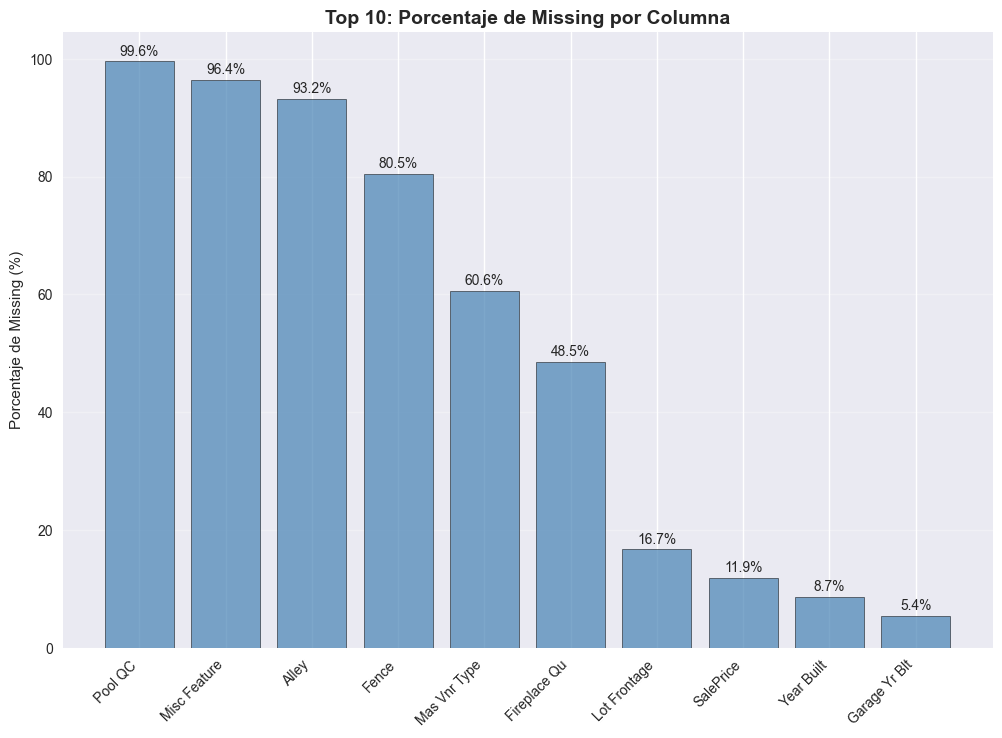

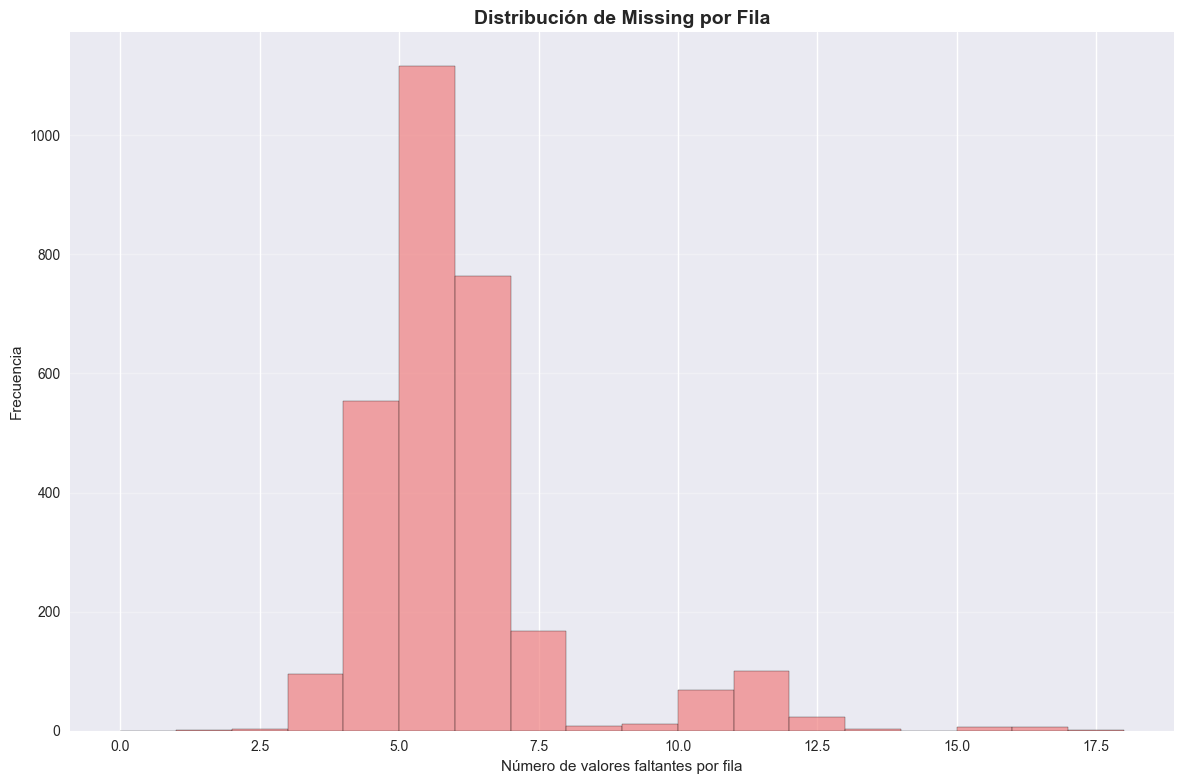

In [4]:
# === ANÁLISIS DE PATRONES DE MISSING DATA ===

# 1. Filtrar solo columnas con missing data para visualización
missing_columns = df.columns[df.isnull().any()].tolist()  # método para detectar missing
print(f"Columnas con missing data: {len(missing_columns)}")
print(f"Columnas: {missing_columns}")

# 2. Visualización mejorada sin missingno
plt.subplot(1, 1, 1)
if len(missing_columns) > 0:
    # Crear estadísticas de missing solo para columnas con missing data
    missing_count = df[missing_columns].isnull().sum()  # método para contar missing
    missing_pct = (missing_count / len(df)) * 100  # calcular porcentaje

    missing_stats_filtered = pd.DataFrame({
        'Column': missing_columns,
        'Missing_Count': missing_count,
        'Missing_Percentage': missing_pct
    }).sort_values('Missing_Percentage', ascending=False).head(10)

    # Crear gráfico de barras más limpio
    bars = plt.bar(range(len(missing_stats_filtered)), missing_stats_filtered['Missing_Percentage'], 
                   color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)  # función para barras
    plt.title('Top 10: Porcentaje de Missing por Columna', fontsize=14, fontweight='bold')
    plt.xticks(range(len(missing_stats_filtered)), missing_stats_filtered['Column'], 
               rotation=45, ha='right')  # función para etiquetas del eje X

    plt.ylabel('Porcentaje de Missing (%)')
    plt.grid(True, alpha=0.3, axis='y')

    # Agregar valores en las barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)
else:
    plt.text(0.5, 0.5, 'No hay missing data', ha='center', va='center', fontsize=16)
    plt.title('Porcentaje de Missing por Columna', fontsize=14, fontweight='bold')

# Distribución de missing por fila
plt.show()
plt.subplot(1, 1, 1)
missing_per_row = df.isnull().sum(axis=1)  # contar missing por fila
plt.hist(missing_per_row, bins=range(0, missing_per_row.max()+2), alpha=0.7, 
         edgecolor='black', color='lightcoral')  # función para histograma
plt.title('Distribución de Missing por Fila', fontsize=14, fontweight='bold')
plt.xlabel('Número de valores faltantes por fila')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
!mkdir -p results/visualizaciones
plt.savefig('results/visualizaciones/missing_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# === CLASIFICACIÓN MCAR/MAR/MNAR ===

print("=== ANÁLISIS DE TIPOS DE MISSING ===")

# 1. Year Built: ¿MCAR o MAR?
print("\n1. YEAR BUILT - Análisis de patrones:")
year_missing = df['Year Built'].isnull()  # método para detectar missing
print("Missing Year Built por Neighborhood:")
print(df.groupby('Neighborhood')['Year Built'].apply(lambda x: x.isnull().sum()))  # contar missing por grupo

print("Missing Year Built por House Style:")
print(df.groupby('House Style')['Year Built'].apply(lambda x: x.isnull().sum()))

# 2. Garage Area: ¿MAR?
print("\n2. GARAGE AREA - Análisis de patrones:")
print("Missing Garage Area por Garage Type:")
print(df.groupby('Garage Type')['Garage Area'].apply(lambda x: x.isnull().sum()))

# 3. SalePrice: ¿MNAR?
print("\n3. SALEPRICE - Análisis de patrones:")
price_missing = df['SalePrice'].isnull()
print("Valores de SalePrice en registros con missing:")
print(df[price_missing]['SalePrice'].describe())  # estadísticas descriptivas

=== ANÁLISIS DE TIPOS DE MISSING ===

1. YEAR BUILT - Análisis de patrones:
Missing Year Built por Neighborhood:
Neighborhood
Blmngtn     4
Blueste     0
BrDale      3
BrkSide    13
ClearCr     3
CollgCr    22
Crawfor    11
Edwards    20
Gilbert    15
Greens      0
GrnHill     0
IDOTRR      7
Landmrk     0
MeadowV     4
Mitchel    14
NAmes      38
NPkVill     2
NWAmes     14
NoRidge     3
NridgHt    15
OldTown    18
SWISU       7
Sawyer      9
SawyerW     6
Somerst    17
StoneBr     5
Timber      4
Veenker     2
Name: Year Built, dtype: int64
Missing Year Built por House Style:
House Style
1.5Fin     28
1.5Unf      2
1Story    136
2.5Fin      0
2.5Unf      3
2Story     67
SFoyer      6
SLvl       14
Name: Year Built, dtype: int64

2. GARAGE AREA - Análisis de patrones:
Missing Garage Area por Garage Type:
Garage Type
2Types     0
Attchd     0
Basment    0
BuiltIn    0
CarPort    0
Detchd     1
Name: Garage Area, dtype: int64

3. SALEPRICE - Análisis de patrones:
Valores de SalePrice en

In [6]:
# === DETECCIÓN DE OUTLIERS CON IQR ===
# "Detectar extremos usando mediana y cuartiles"
# "Cuándo usar: distribuciones asimétricas / colas pesadas / presencia de outliers"
if "Year Built" in df.columns:
    df["Year Built"] = pd.to_numeric(df["Year Built"], errors="coerce")

# === DETECCIÓN DE OUTLIERS: IQR y Z-SCORE (robustas) ===
def detect_outliers_iqr(df, column, factor=1.5):
    """Outliers por IQR. Devuelve (df_outliers, lower, upper)."""
    x = pd.to_numeric(df[column], errors="coerce")
    x_no_na = x.dropna().astype(float).values
    if x_no_na.size == 0:
        # sin datos válidos
        return df.iloc[[]], np.nan, np.nan
    q1 = np.percentile(x_no_na, 25)
    q3 = np.percentile(x_no_na, 75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    mask = (pd.to_numeric(df[column], errors="coerce") < lower) | (pd.to_numeric(df[column], errors="coerce") > upper)
    return df[mask], lower, upper

# Analizar outliers en columnas numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns  # método para seleccionar columnas numéricas
outlier_analysis = {}

for col in numeric_columns:
    if not df[col].isnull().all():  # método para verificar si hay missing data
        outliers, lower, upper = detect_outliers_iqr(df, col)
        outlier_analysis[col] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len(df)) * 100,
            'lower_bound': lower,
            'upper_bound': upper
        }

outlier_df = pd.DataFrame(outlier_analysis).T
print("=== ANÁLISIS DE OUTLIERS (IQR) ===")
print("Útil cuando la distribución está chueca o con colas largas")
print(outlier_df)

# Análisis adicional de outliers
print("\n=== RESUMEN DE OUTLIERS ===")
total_outliers = outlier_df['count'].sum()  # método para sumar outliers
print(f"Total de outliers detectados: {total_outliers}")
print(f"Porcentaje promedio de outliers: {outlier_df['percentage'].mean():.2f}%")  # método para calcular media
print(f"Columna con más outliers: {outlier_df['count'].max()}")  # método para encontrar máximo

=== ANÁLISIS DE OUTLIERS (IQR) ===
Útil cuando la distribución está chueca o con colas largas
                 count  percentage   lower_bound   upper_bound
Order              0.0    0.000000 -1.463500e+03  4.394500e+03
PID                0.0    0.000000 -3.957909e+07  1.475237e+09
MS SubClass      208.0    7.098976 -5.500000e+01  1.450000e+02
Lot Frontage     187.0    6.382253  2.500000e+01  1.130000e+02
Lot Area         127.0    4.334471  1.267750e+03  1.772775e+04
Overall Qual       4.0    0.136519  2.000000e+00  1.000000e+01
Overall Cond     252.0    8.600683  3.500000e+00  7.500000e+00
Year Built         8.0    0.273038  1.885000e+03  2.069000e+03
Year Remod/Add     0.0    0.000000  1.906500e+03  2.062500e+03
Mas Vnr Area     200.0    6.825939 -2.460000e+02  4.100000e+02
BsmtFin SF 1      15.0    0.511945 -1.101000e+03  1.835000e+03
BsmtFin SF 2     351.0   11.979522  0.000000e+00  0.000000e+00
Bsmt Unf SF       56.0    1.911263 -6.555000e+02  1.676500e+03
Total Bsmt SF    123.0  

In [7]:
# === DETECCIÓN DE OUTLIERS CON Z-SCORE ===
# "Cuándo usar: distribución aprox. campana y sin colas raras"
# "Regla: 3 pasos (desvios) desde el promedio = raro"

def detect_outliers_zscore(df, column, threshold=3):
    """Detectar outliers usando Z-Score - Regla: 3 desvios desde el promedio = raro"""
    from scipy import stats
    z_scores = np.abs(stats.zscore(df[column].dropna()))
    outlier_indices = df[column].dropna().index[z_scores > threshold]
    return df.loc[outlier_indices]

# Comparar métodos de detección
print("\n=== COMPARACIÓN DE MÉTODOS DE DETECCIÓN ===")
for col in ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area']:
    if col in df.columns and not df[col].isnull().all():
        iqr_outliers = detect_outliers_iqr(df, col)
        zscore_outliers = detect_outliers_zscore(df, col)

        print(f"\n{col}:")
        print(f"  IQR outliers: {len(iqr_outliers[0])} ({len(iqr_outliers[0])/len(df)*100:.1f}%)")
        print(f"  Z-Score outliers: {len(zscore_outliers)} ({len(zscore_outliers)/len(df)*100:.1f}%)")


=== COMPARACIÓN DE MÉTODOS DE DETECCIÓN ===

SalePrice:
  IQR outliers: 55 (1.9%)
  Z-Score outliers: 29 (1.0%)

Lot Area:
  IQR outliers: 127 (4.3%)
  Z-Score outliers: 29 (1.0%)

Year Built:
  IQR outliers: 8 (0.3%)
  Z-Score outliers: 7 (0.2%)

Garage Area:
  IQR outliers: 42 (1.4%)
  Z-Score outliers: 17 (0.6%)


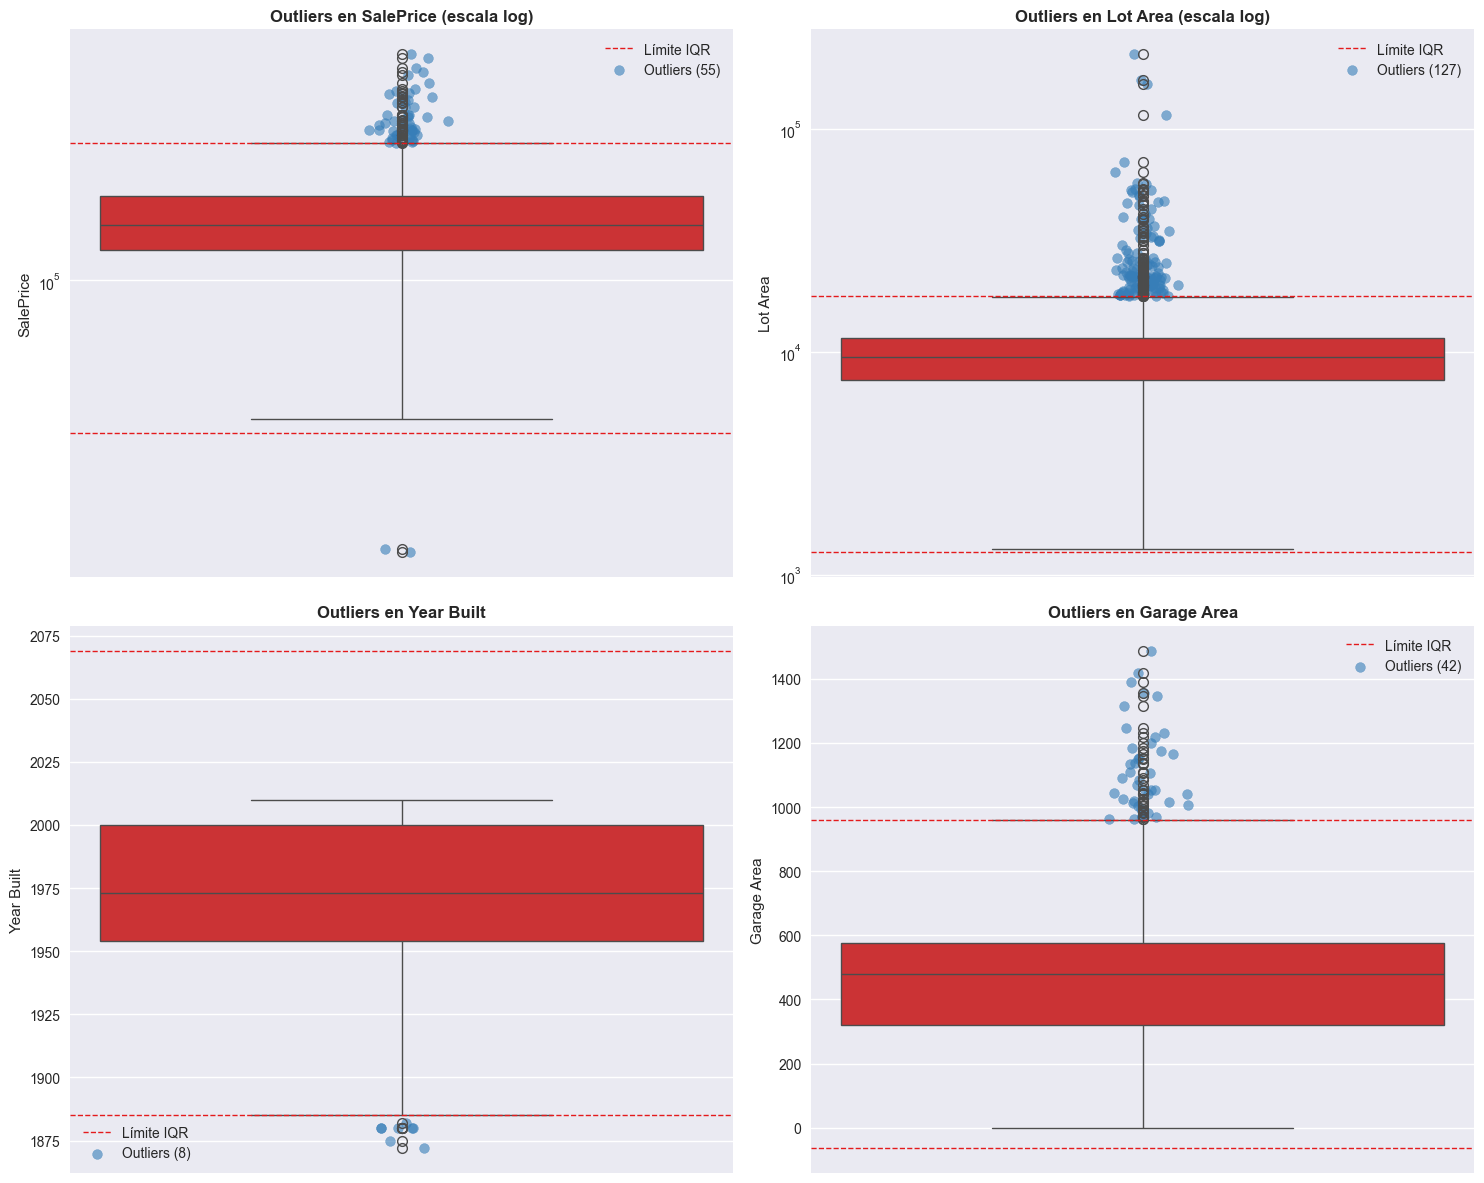

In [8]:
# === VISUALIZAR OUTLIERS ===
os.makedirs('results/visualizaciones', exist_ok=True)

cols = ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # función para crear subplots
axes = axes.ravel()  # método para aplanar array

for i, col in enumerate(cols):
    if col not in df.columns:
        axes[i].set_visible(False)
        continue

    # convertir a numérico de forma segura
    y = pd.to_numeric(df[col], errors='coerce').dropna()

    if y.empty:
        axes[i].axis('off')
        axes[i].text(0.5, 0.5, f"{col}: sin datos numéricos", ha='center', va='center', fontsize=11)
        continue

    # Boxplot usando el vector numérico (evita inferencias de dtype de seaborn)
    sns.boxplot(y=y, ax=axes[i])  # función para boxplot
    axes[i].set_title(f'Outliers en {col}', fontweight='bold')
    axes[i].set_ylabel(col)

    # Outliers por IQR y bandas
    iqr_df, lower, upper = detect_outliers_iqr(df, col)
    out_vals = pd.to_numeric(iqr_df[col], errors='coerce').dropna()

    if np.isfinite(lower):
        axes[i].axhline(lower, linestyle='--', linewidth=1, label='Límite IQR')
    if np.isfinite(upper):
        axes[i].axhline(upper, linestyle='--', linewidth=1)

    # Marcar outliers con un leve jitter en X para que se vean
    if len(out_vals) > 0:
        jitter_x = np.random.normal(loc=0, scale=0.02, size=len(out_vals))
        axes[i].scatter(jitter_x, out_vals, alpha=0.6, s=50, label=f'Outliers ({len(out_vals)})') # función para scatter
        axes[i].legend()  # método para mostrar leyenda

    # Opcional: si la variable es muy sesgada, usar escala log
    if col in ['Lot Area', 'SalePrice'] and y.skew() > 1:
        axes[i].set_yscale('log')
        axes[i].set_title(f'Outliers en {col} (escala log)', fontweight='bold')

plt.tight_layout() # función para ajustar layout
plt.savefig('results/visualizaciones/outliers_analysis.png', dpi=300, bbox_inches='tight') # función para guardar
plt.show() # función para mostrar gráfico

In [9]:
# === IMPLEMENTAR ESTRATEGIAS DE IMPUTACIÓN ===
# "Rellenar no es gratis; hacelo columna a columna y documentá"
# "Num: mediana (si cola pesada) / media (si ~normal)"
# "Cat: moda o 'Unknown' (+ flag si sospecha MNAR)"

def impute_missing_data(df, strategy='median'):
    """Implementar diferentes estrategias de imputación - Reglas simples de la clase"""
    df_imputed = df.copy()

    for col in df.columns:
        if df[col].isnull().any():
            if df[col].dtype in ['int64', 'float64']:
                if strategy == 'mean':
                    df_imputed[col].fillna(df[col].mean(), inplace=True)  # imputar con media
                elif strategy == 'median':
                    df_imputed[col].fillna(df[col].median (), inplace=True)  # imputar con mediana
                elif strategy == 'mode':
                    df_imputed[col].fillna(df[col].mode()[0], inplace=True)  # imputar con moda
            else:
                # Para variables categóricas
                df_imputed[col].fillna(df[col].mode()[0], inplace=True)  # imputar con moda

    return df_imputed

# Probar diferentes estrategias
strategies = ['mean', 'median', 'mode']
imputed_datasets = {}

for strategy in strategies:
    imputed_datasets[strategy] = impute_missing_data(df, strategy)
    print(f"Estrategia {strategy}: {imputed_datasets[strategy].isnull().sum().sum()} missing values restantes")

Estrategia mean: 0 missing values restantes
Estrategia median: 0 missing values restantes
Estrategia mode: 0 missing values restantes


In [10]:
def smart_imputation(df, *, impute_saleprice=True):
    """Imputación inteligente robusta a dtypes y NaN."""
    df_imputed = df.copy()

    # --- 0) Asegurar dtypes numéricos donde corresponde ---
    for c in ["Year Built", "Garage Area", "SalePrice"]:
        if c in df_imputed.columns:
            df_imputed[c] = pd.to_numeric(df_imputed[c], errors="coerce")  

    # --- 1) Year Built: mediana por (Neighborhood, House Style) -> Neighborhood -> global ---
    if {"Neighborhood", "House Style", "Year Built"}.issubset(df_imputed.columns):
        grp_med = df_imputed.groupby(["Neighborhood", "House Style"])["Year Built"].transform("median")  
        df_imputed["Year Built"] = df_imputed["Year Built"].fillna(grp_med)  

        nb_med = df_imputed.groupby("Neighborhood")["Year Built"].transform("median")
        df_imputed["Year Built"] = df_imputed["Year Built"].fillna(nb_med)

        df_imputed["Year Built"] = df_imputed["Year Built"].fillna(df_imputed["Year Built"].median( ))  
        # Año entero nullable
        df_imputed["Year Built"] = df_imputed["Year Built"].round( ).astype("Int64")  

    # --- 2) Garage Area: MNAR → indicador + 0; resto por mediana del barrio ---
    if "Garage Area" in df_imputed.columns:
        df_imputed["GarageArea_was_na"] = df_imputed["Garage Area"].isna( ).astype("Int8")  

        # Si hay "Garage Cars", usarlo para inferir "sin garaje" (0 área)
        if "Garage Cars" in df_imputed.columns:
            no_garage_mask = (df_imputed["Garage Cars"].fillna(0) == 0) & df_imputed["Garage Area"].isna()
            df_imputed.loc[no_garage_mask, "Garage Area"] = 0.0

        # Para los NaN restantes: mediana por Neighborhood, luego global
        if "Neighborhood" in df_imputed.columns:
            med_gar = df_imputed.groupby("Neighborhood")["Garage Area"].transform("median")
            df_imputed["Garage Area"] = df_imputed["Garage Area"].fillna(med_gar)

        df_imputed["Garage Area"] = df_imputed["Garage Area"].fillna(df_imputed["Garage Area"].median())

    # --- 3) SalePrice: mediana por Neighborhood (opcional) ---
    if impute_saleprice and {"Neighborhood", "SalePrice"}.issubset(df_imputed.columns):
        nb_price = df_imputed.groupby("Neighborhood")["SalePrice"].transform("median")
        df_imputed["SalePrice"] = df_imputed["SalePrice"].fillna(nb_price) 
        df_imputed["SalePrice"] = df_imputed["SalePrice"].fillna(df_imputed["SalePrice"].median())

    # --- 4) Garage Type: moda global (MCAR); manejar categorías ---
    if "Garage Type" in df_imputed.columns:
        # evitar problemas si es category
        if pd.api.types.is_categorical_dtype(df_imputed["Garage Type"]):  
            df_imputed["Garage Type"] = df_imputed["Garage Type"].astype("object")
        mode_val = df_imputed["Garage Type"].dropna().mode( )  
        fill_val = mode_val.iloc[0] if not mode_val.empty else "Unknown"
        df_imputed["Garage Type"] = df_imputed["Garage Type"].fillna(fill_val)  

    return df_imputed

# Aplicar
df_smart_imputed = smart_imputation(df)
print("=== IMPUTACIÓN INTELIGENTE ===")
print(f"Missing restantes: {int(df_smart_imputed.isnull().sum().sum())}")

=== IMPUTACIÓN INTELIGENTE ===
Missing restantes: 15591


In [11]:
# === ANTI-LEAKAGE BÁSICO ===
# "No espiés el examen: fit en TRAIN, transform en VALID/TEST"
# "Split: X_train / X_valid / X_test"
# "imputer.fit(X_train) → transform al resto"

from sklearn.model_selection import train_test_split

# 1. Split de datos (ANTES de imputar)
X = df.drop('SalePrice', axis=1)  # features
y = df['SalePrice']  # target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("=== SPLIT DE DATOS ===")
print(f"Train: {X_train.shape[0]} registros")
print(f"Valid: {X_valid.shape[0]} registros") 
print(f"Test: {X_test.shape[0]} registros")

# 2. Imputar SOLO en train, luego transformar
from sklearn.impute import SimpleImputer

# Separar columnas numéricas y categóricas
numeric_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Columnas numéricas: {len(numeric_columns)}")
print(f"Columnas categóricas: {len(categorical_columns)}")

# Crear imputers para cada tipo de dato
numeric_imputer = SimpleImputer(strategy='median')  # estrategia para numéricas
categorical_imputer = SimpleImputer(strategy='most_frequent')  # estrategia para categóricas

# Ajustar imputers SOLO con train
numeric_imputer.fit(X_train[numeric_columns])  # ajustar numéricas
categorical_imputer.fit(X_train[categorical_columns])  # ajustar categóricas

# Transformar todos los conjuntos
X_train_numeric = numeric_imputer.transform(X_train[numeric_columns])  # transformar numéricas
X_train_categorical = categorical_imputer.transform(X_train[categorical_columns])  # transformar categóricas

X_valid_numeric = numeric_imputer.transform(X_valid[numeric_columns])
X_valid_categorical = categorical_imputer.transform(X_valid[categorical_columns])

X_test_numeric = numeric_imputer.transform(X_test[numeric_columns])
X_test_categorical = categorical_imputer.transform(X_test[categorical_columns])

print("\n✅ Anti-leakage aplicado: fit solo en train, transform en todo")

=== SPLIT DE DATOS ===
Train: 1758 registros
Valid: 586 registros
Test: 586 registros
Columnas numéricas: 38
Columnas categóricas: 43

✅ Anti-leakage aplicado: fit solo en train, transform en todo


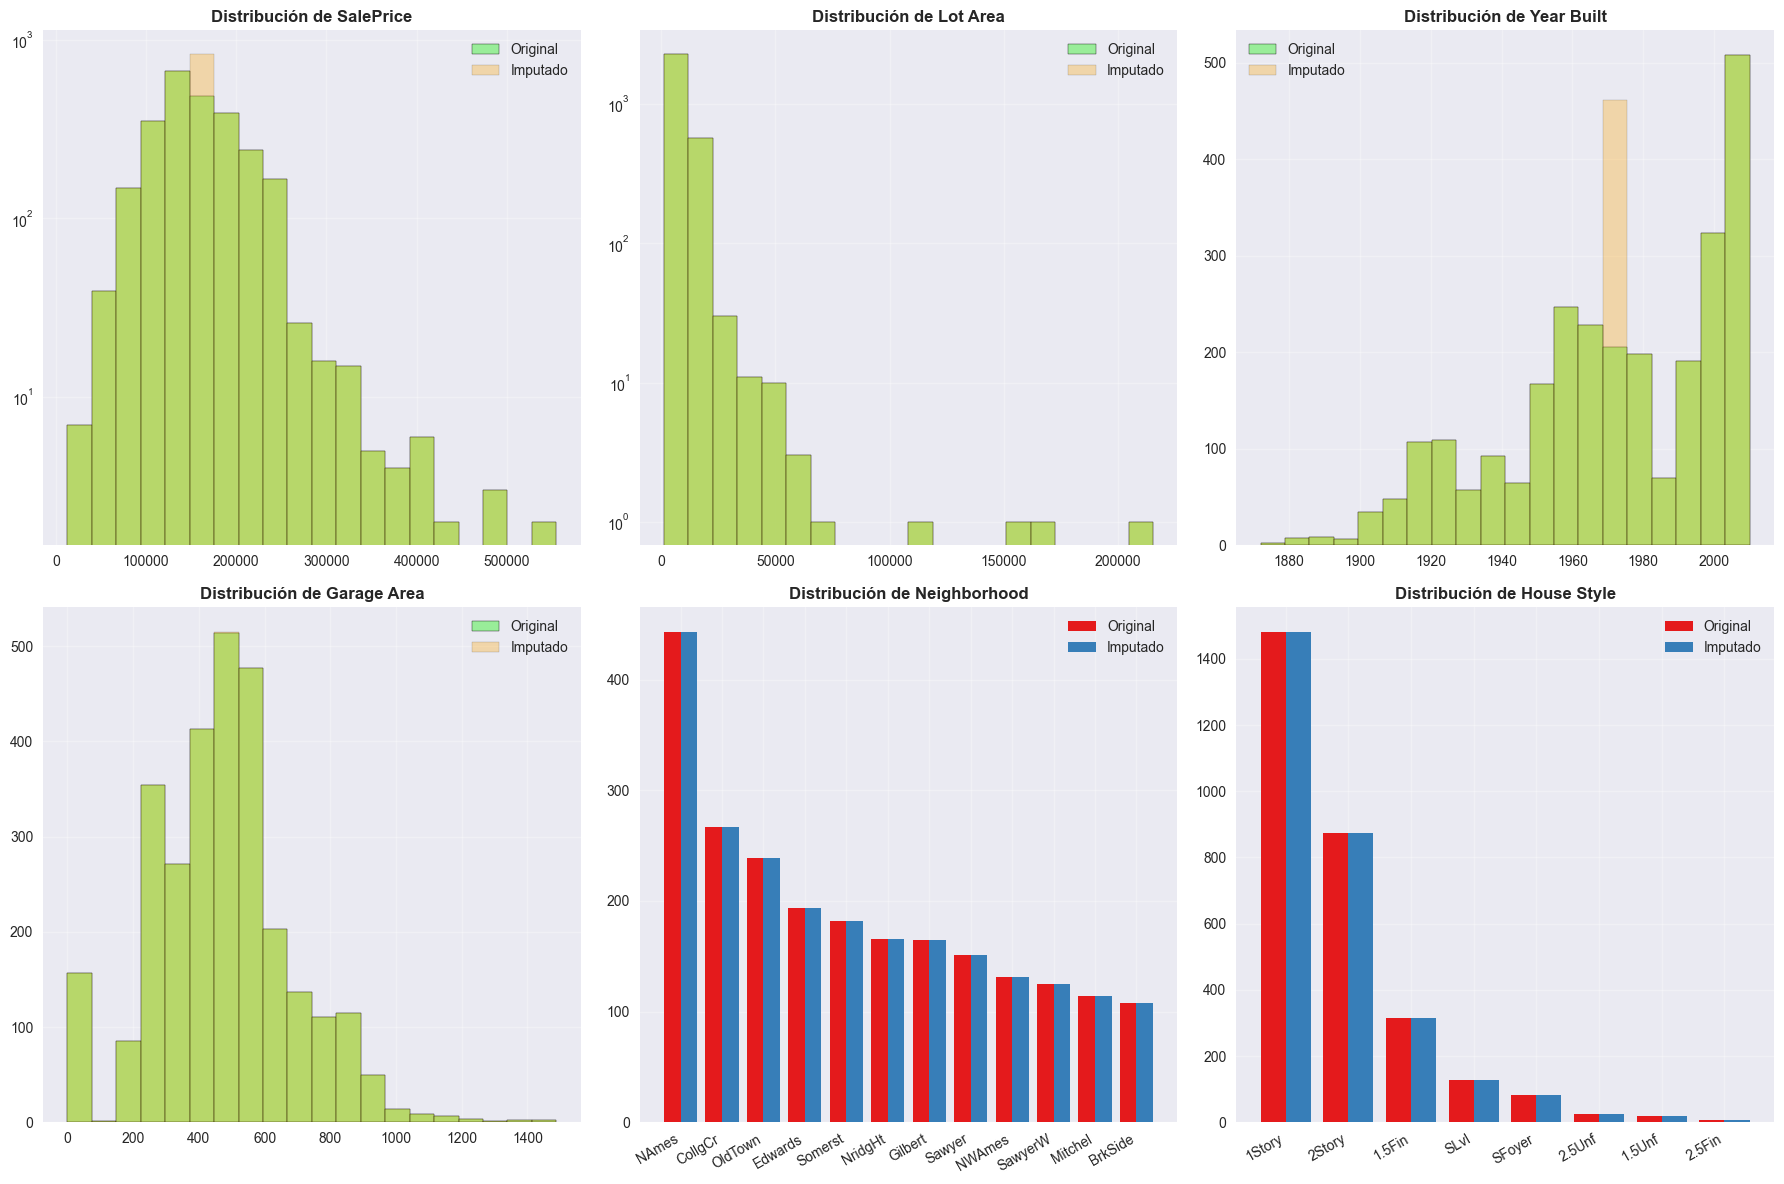

Columnas seleccionadas para correlaciones: ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area', 'Overall Qual', 'Gr Liv Area', 'Total Bsmt SF']


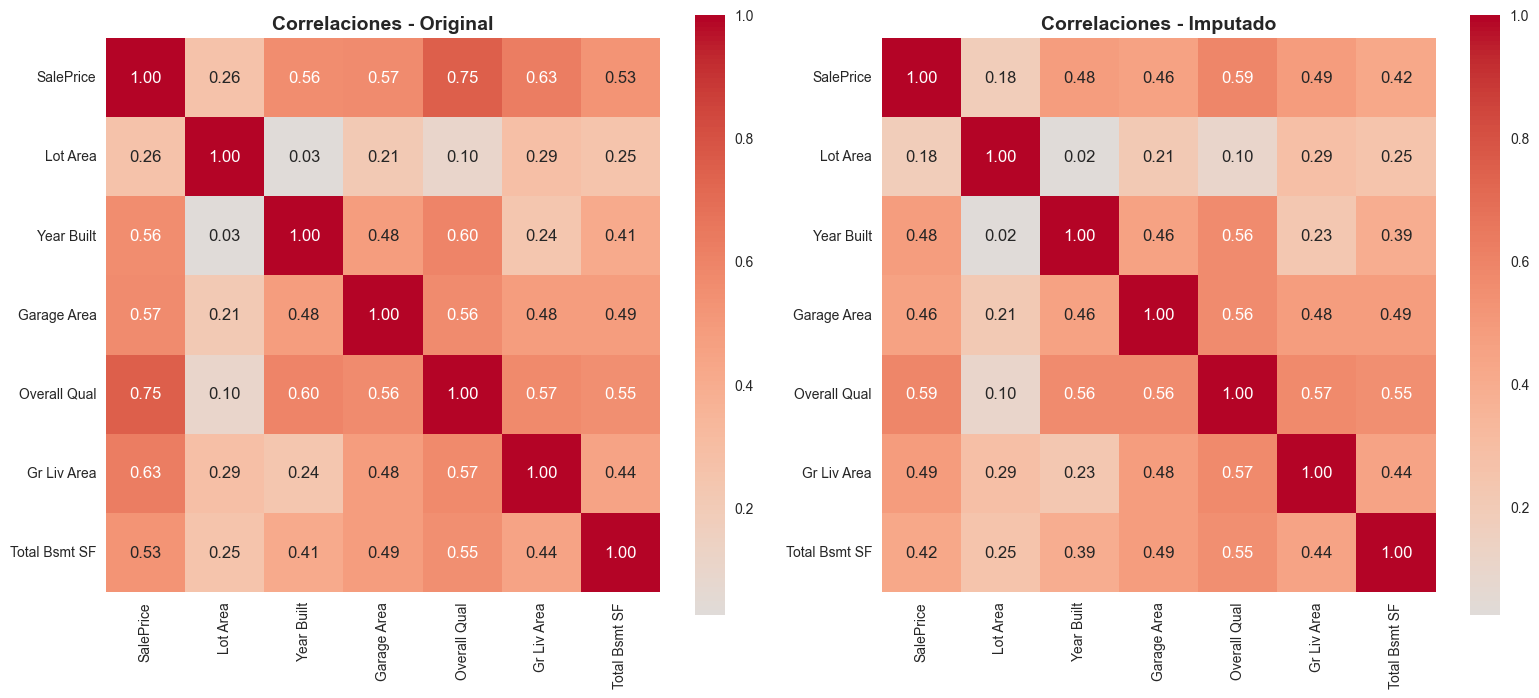


=== DIFERENCIAS EN CORRELACIONES ===
Cambios en correlaciones (Imputado - Original):
               SalePrice  Lot Area  Year Built  Garage Area  Overall Qual  \
SalePrice          0.000    -0.074      -0.078       -0.105        -0.165   
Lot Area          -0.074     0.000      -0.001       -0.000         0.000   
Year Built        -0.078    -0.001       0.000       -0.022        -0.031   
Garage Area       -0.105    -0.000      -0.022        0.000        -0.000   
Overall Qual      -0.165     0.000      -0.031       -0.000         0.000   
Gr Liv Area       -0.141     0.000      -0.010       -0.000         0.000   
Total Bsmt SF     -0.103     0.000      -0.018       -0.000        -0.000   

               Gr Liv Area  Total Bsmt SF  
SalePrice           -0.141         -0.103  
Lot Area             0.000          0.000  
Year Built          -0.010         -0.018  
Garage Area         -0.000         -0.000  
Overall Qual         0.000         -0.000  
Gr Liv Area          0.000       

In [12]:
from pandas.api.types import is_numeric_dtype

# 1) Crear df_imputed con imputación simple, robusta a dtypes
df_imputed = df.copy()

for col in df.columns:
    s = df[col]
    # Si es numérica o puede convertirse a numérica, imputar mediana
    if is_numeric_dtype(s) or (s.dtype == "object"):
        s_num = pd.to_numeric(s, errors="coerce")
        if s_num.notna().any():
            df_imputed[col] = s_num.fillna(s_num.median()) # imputar numéricas con mediana
            continue
    # Caso categórico: imputar con moda (si existe), sino "Unknown"
    moda = s.dropna().mode() # imputar categóricas con moda
    fill_val = moda.iloc[0] if not moda.empty else "Unknown"
    df_imputed[col] = s.fillna(fill_val)

# 2) Comparar distribuciones (hist para numéricas, barras para categóricas)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

cols_to_plot = ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area', 'Neighborhood', 'House Style']
for i, col in enumerate(cols_to_plot):
    if col not in df.columns:
        axes[i].axis('off')
        axes[i].set_title(f'{col} no existe', fontweight='bold')
        continue

    s_orig = df[col]
    s_imp = df_imputed[col]

    # Intentar tratar como numérico (coerce) para decidir el tipo de gráfico
    s_orig_num = pd.to_numeric(s_orig, errors='coerce')
    s_imp_num = pd.to_numeric(s_imp, errors='coerce')

    if s_orig_num.notna().any() and s_imp_num.notna().any():
        # NUMÉRICAS → hist
        # Mismo rango/bins para una comparación justa
        data_combined = pd.concat([s_orig_num.dropna(), s_imp_num.dropna()])
        bins = np.histogram_bin_edges(data_combined, bins=20)

        axes[i].hist(s_orig_num.dropna(), bins=bins, alpha=0.9, label='Original',
                     color='lightgreen', edgecolor='black')
        axes[i].hist(s_imp_num.dropna(), bins=bins, alpha=0.3, label='Imputado',
                     color='orange', edgecolor='black')

        # Si está muy sesgada, te puede servir escala log
        if col in ['Lot Area', 'SalePrice'] and s_orig_num.dropna().skew() > 1:
            axes[i].set_yscale('log')

    else:
        # CATEGÓRICAS → barras (top-K categorías para legibilidad)
        K = 12
        vc_orig = s_orig.astype('object').fillna('Missing').value_counts().head(K)
        vc_imp  = s_imp.astype('object').fillna('Missing').value_counts().head(K)
        cats = list(dict.fromkeys(list(vc_orig.index) + list(vc_imp.index)))[:K]  # unión ordenada

        vc_orig = vc_orig.reindex(cats, fill_value=0)
        vc_imp  = vc_imp.reindex(cats, fill_value=0)

        x = np.arange(len(cats))
        w = 0.4
        axes[i].bar(x - w/2, vc_orig.values, width=w, label='Original')
        axes[i].bar(x + w/2, vc_imp.values,  width=w, label='Imputado')
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(cats, rotation=30, ha='right')

    axes[i].set_title(f'Distribución de {col}', fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/visualizaciones/distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 3) Correlaciones (solo numéricas y con coerción segura)
important_cols = ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area', 'Overall Qual', 'Gr Liv Area', 'Total Bsmt SF']
available_cols = [c for c in important_cols if c in df.columns]
print(f"Columnas seleccionadas para correlaciones: {available_cols}")

df_num_original = df[available_cols].apply(pd.to_numeric, errors='coerce')
df_num_imputed  = df_imputed[available_cols].apply(pd.to_numeric, errors='coerce')

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

corr_original = df_num_original.corr(numeric_only=True)  # método para matriz de correlación
sns.heatmap(corr_original, annot=True, cmap='coolwarm', center=0, ax=axes[0],
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
axes[0].set_title('Correlaciones - Original', fontweight='bold', fontsize=14)

corr_imputed = df_num_imputed.corr(numeric_only=True)  # método para matriz de correlación
sns.heatmap(corr_imputed, annot=True, cmap='coolwarm', center=0, ax=axes[1],
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
axes[1].set_title('Correlaciones - Imputado', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('results/visualizaciones/correlation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 4) Diferencias en correlaciones
print("\n=== DIFERENCIAS EN CORRELACIONES ===")
corr_diff = corr_imputed - corr_original
print("Cambios en correlaciones (Imputado - Original):")
print(corr_diff.round(3))

In [13]:
# === CREAR PIPELINE CON SKLEARN ===

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def create_cleaning_pipeline():
    """Crear pipeline de limpieza reproducible"""

    # Definir columnas numéricas y categóricas
    numeric_features = ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area']
    categorical_features = ['Neighborhood', 'House Style', 'Garage Type']

    # Transformadores
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # estrategia de imputación
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # estrategia de imputación
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combinar transformadores
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    return preprocessor

# Crear y probar pipeline
preprocessor = create_cleaning_pipeline()

# Aplicar pipeline
X_cleaned = preprocessor.fit_transform(df)  # método para aplicar transformaciones
print(f"Shape después del pipeline: {X_cleaned.shape}")
print(f"Tipo de datos: {type(X_cleaned)}")

Shape después del pipeline: (2930, 46)
Tipo de datos: <class 'scipy.sparse._csr.csr_matrix'>


# Preguntas de Reflexión

## Responde estas preguntas en tu notebook:

1. ¿Qué tipo de missing data identificaste en cada columna? Justifica tu clasificación.

2. ¿Por qué elegiste esas estrategias de imputación específicas? ¿Qué alternativas consideraste?

3. ¿Cómo podrían las decisiones de imputación afectar a diferentes grupos demográficos? (ej: barrios, tipos de vivienda)

4. ¿Qué información adicional necesitarías para tomar mejores decisiones sobre los outliers?

5. ¿Cómo garantizas que tu pipeline sea reproducible y transparente?

# RESPUESTAS:

1.  

MCAR → cuando el faltante es un error de carga o se distribuye al azar sin patrón.

MNAR → cuando el faltante sí tiene un significado real.

MAR → cuando los faltantes dependen de otra variable.

* Year Built es MCAR o MAR, puede ser de error de carga o falta por otras variables observadas.
* Garage Area / Garage Type son MNAR (faltantes no al azar) ni un error de carga. Falta porque no existe.
* SalePrice no pudimos clasificar porque no hay NaN en SalePrice según el código.

2. 

* Numéricas: mediana cuando la distribución está sesgada y media si es simétrica. Sería mediana si cola pesada y media si ~normal.
* Categóricas: moda para mantener la categoría más frecuente.
* Alternativas: modelos predictivos de imputación o condicional.

3. 
* Si imputo SalePrice con la mediana global, puedo sesgar los precios hacia zonas de menor o mayor valor. Esto impacta en comparaciones entre barrios porque puede parecer que hay menos desigualdad o diversidad de viviendas de la que existe en realidad.

4. 
* Año de construcción promedio/mínimo/máximo en la ciudad.
* Tamaño promedio de casas y garajes en cada barrio.
* Respuesta a los valores faltantes o extremos (si son errores de carga o que les paso).

5. 
* Guardar el pipeline entrenado para aplicarlo siempre igual a nuevos datos.
* Documentando las decisiones de imputación o generando resumen de outliers, valores imputados, cambios.


# Práctica 6: Feature Scaling & Anti-Leakage Pipeline - Exploración Abierta
CONTINUACIÓN DE LA PRÁCTICA ANTERIOR

Antes de continuar, responde estas preguntas explorando el dataset:

1. ¿Cuáles son las 5 columnas numéricas con las escalas más diferentes?
2. ¿Hay outliers evidentes que podrían afectar el escalado?
3. ¿Qué variable será nuestro target para predicción?

In [14]:
print(df_imputed.columns.tolist())

['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Wood Deck 

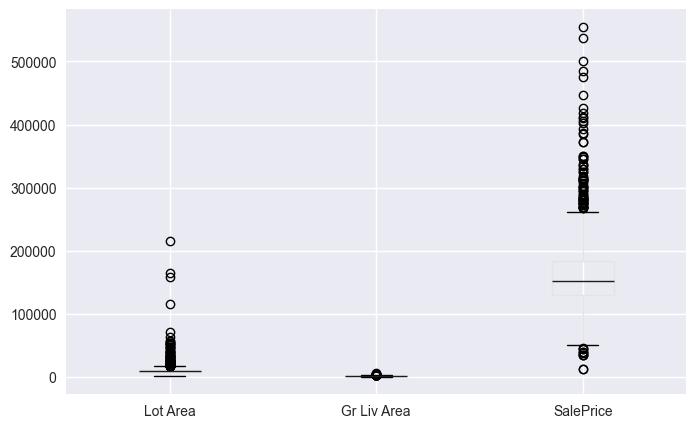

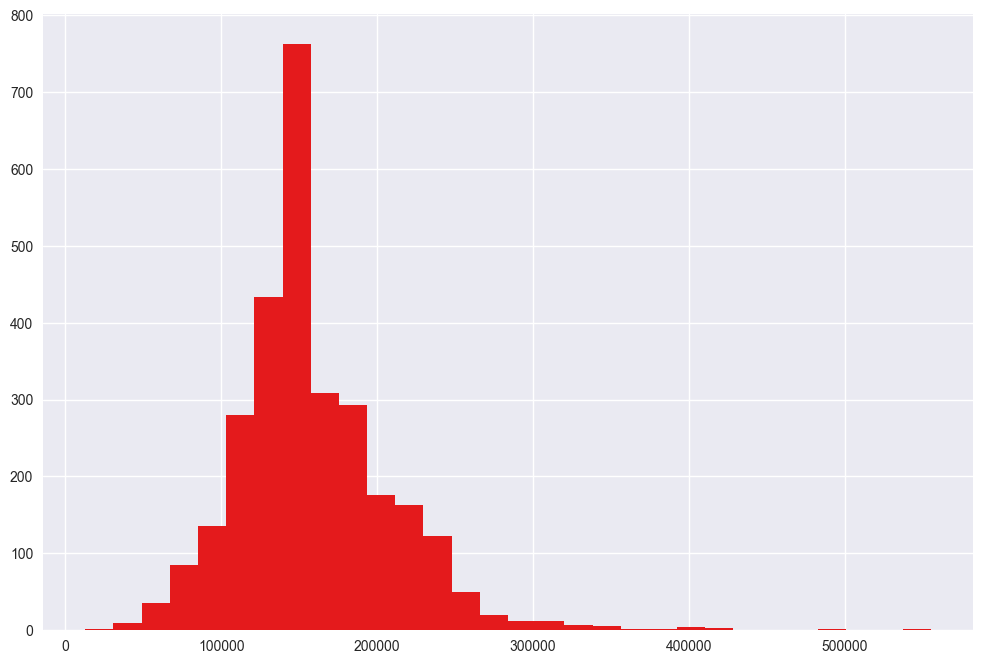

In [15]:
# Seleccionar columnas numéricas
numeric_cols = df_imputed.select_dtypes(include="number").columns

# Estadísticas y rango (max - min)
desc = df_imputed[numeric_cols].describe().T
desc["range"] = desc["max"] - desc["min"]

# Mostrar las 5 con mayor rango
desc.sort_values("range", ascending=False).head(5)

# Boxplot de algunas variables grandes
df_imputed[["Lot Area", "Gr Liv Area", "SalePrice"]].boxplot(figsize=(8,5))
plt.show()

# Opcional: ver máximos de todas las numéricas
df_imputed[numeric_cols].max().sort_values(ascending=False).head(10)

# Revisar la variable SalePrice
df_imputed["SalePrice"].describe()

# Visualizar distribución del target
df_imputed["SalePrice"].hist(bins=30)
plt.show()



Respuestas:

1. Al mirar el boxplot, se nota que variables como Lot Area, Gr Liv Area y sobre todo SalePrice tienen valores que llegan mucho más alto que el resto (rangos de cientos de miles).
Si comparás con otras columnas numéricas que apenas varían en decenas o centenas, se ve claramente que estas tres están en escalas muy distintas. Sumando a eso, suelen aparecer también Total Bsmt SF o 1st Flr SF con rangos altos.

2. Sí, en el boxplot se ven muchos círculos separados del resto, que representan outliers:
    - En Lot Area hay terrenos excepcionalmente grandes.
    - En Gr Liv Area aparecen casas con superficies habitables mucho más altas que la mayoría.
    - En SalePrice se observan viviendas con precios muy superiores al rango típico.
Estos valores atípicos podrían afectar el escalado porque estiran las escalas de esas variables.

3. El histograma de SalePrice muestra claramente la distribución del precio de venta de las casas, con la mayoría concentrada entre 100.000 y 200.000, y unos pocos casos muy altos.
Esto confirma que la variable de interés para predecir es SalePrice.

=== INFORMACIÓN GENERAL DEL DATASET ===
Dimensiones: (2930, 82)

Tipos de datos:
object     43
int64      26
float64    13
Name: count, dtype: int64

📊 Columnas numéricas encontradas: 39

🔍 TU ANÁLISIS: Examina las escalas
Estadísticas de las primeras 10 columnas numéricas:
            Order           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2930.00000  2.930000e+03  2930.000000   2930.000000    2930.000000   
mean   1465.50000  7.144645e+08    57.387372     69.019795   10147.921843   
std     845.96247  1.887308e+08    42.638025     21.326422    7880.017759   
min       1.00000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     733.25000  5.284770e+08    20.000000     60.000000    7440.250000   
50%    1465.50000  5.354536e+08    50.000000     68.000000    9436.500000   
75%    2197.75000  9.071811e+08    70.000000     78.000000   11555.250000   
max    2930.00000  1.007100e+09   190.000000    313.000000  215245.000000   

       Overall Qual  Overall Co

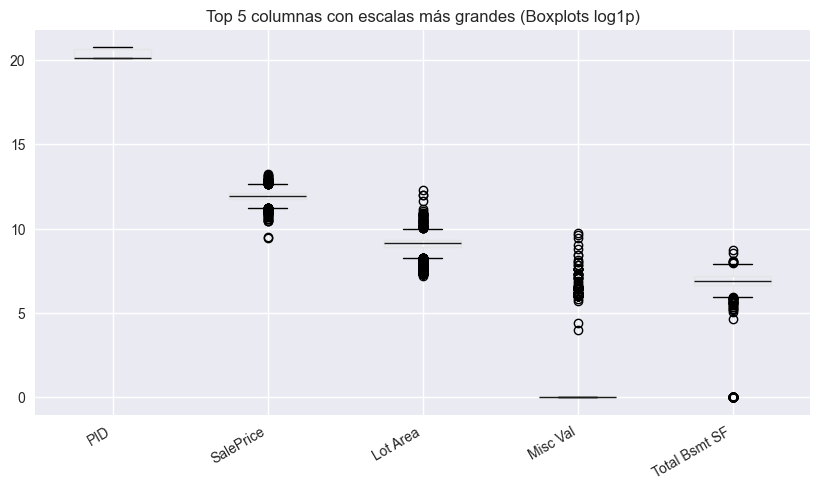

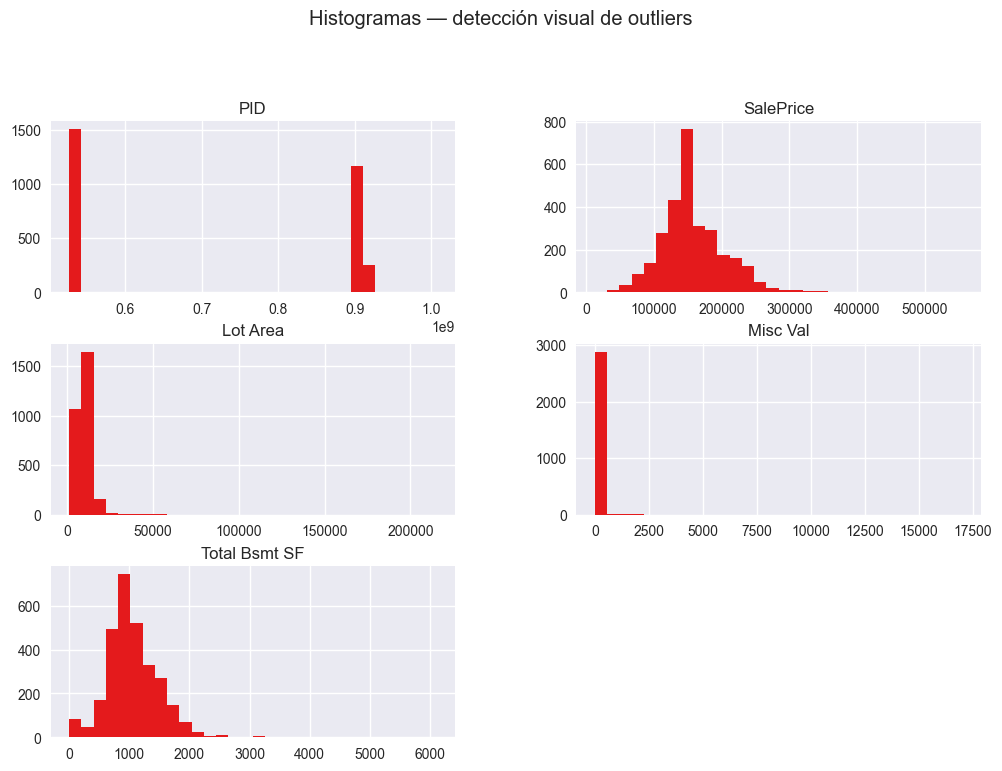

<Figure size 1000x500 with 0 Axes>

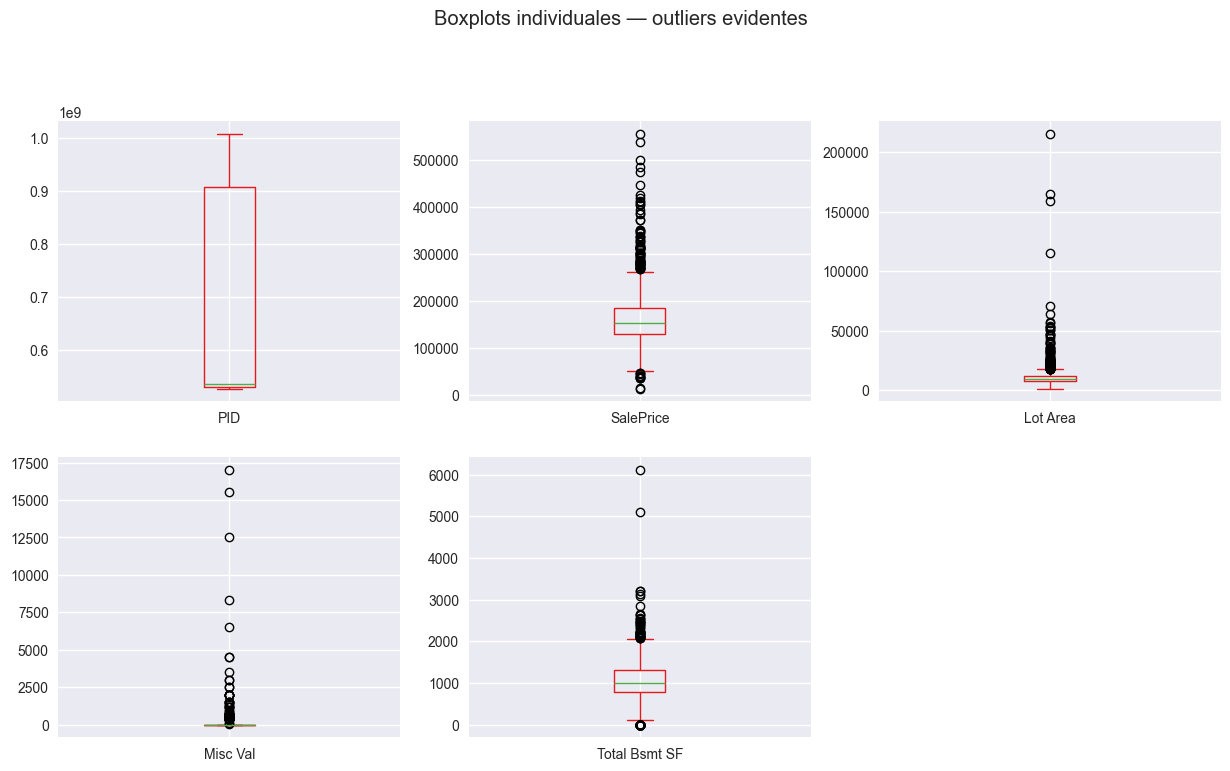

In [16]:
# === EXPLORACIÓN INICIAL ===

# Tu turno: explora las escalas
print("=== INFORMACIÓN GENERAL DEL DATASET ===")
print(f"Dimensiones: {df_imputed.shape}")
print(f"\nTipos de datos:")
print(df_imputed.dtypes.value_counts())

# Identifica columnas numéricas
numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n📊 Columnas numéricas encontradas: {len(numeric_cols)}")

# Tu análisis: ¿cuáles tienen escalas MUY diferentes?
print("\n🔍 TU ANÁLISIS: Examina las escalas")
print("Estadísticas de las primeras 10 columnas numéricas:")
print(df_imputed[numeric_cols[:10]].describe())

# Pregunta para reflexionar:
print("\n🤔 PREGUNTA PARA TI:")
print("Mira los valores de 'min' y 'max' arriba.")
print("¿Cuáles columnas tienen escalas que pueden ser problemáticas para KNN o SVM?")

# Graficas de ayuda para las primeras dos preguntas
# Seleccionar columnas numéricas
numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns.tolist()

# Calcular rango por columna
rangos = {col: df_imputed[col].max() - df_imputed[col].min() for col in numeric_cols}
top5_cols = sorted(rangos, key=rangos.get, reverse=True)[:5]

print("Top 5 columnas con escalas más grandes:", top5_cols)

# Boxplot en log (para ver mejor diferencias y colas largas)
plt.figure(figsize=(10,5))
np.log1p(df_imputed[top5_cols]).boxplot()
plt.title("Top 5 columnas con escalas más grandes (Boxplots log1p)")
plt.xticks(rotation=30, ha='right')
plt.show()

df_imputed[top5_cols].hist(bins=30, figsize=(12,8))
plt.suptitle("Histogramas — detección visual de outliers", y=1.02)
plt.show()

# Otra forma: boxplots solo para resaltar outliers
plt.figure(figsize=(10,5))
df_imputed[top5_cols].plot(kind="box", subplots=True, layout=(2,3), figsize=(15,8))
plt.suptitle("Boxplots individuales — outliers evidentes", y=1.02)
plt.show()

Al observar los valores de mínimo y máximo, se nota que algunas variables tienen rangos muy superiores al resto. Por ejemplo, Lot Area varía entre 1.300 y más de 215.000, PID está en el orden de cientos de millones y Order llega hasta 2.930. También se destacan Mas Vnr Area (0 a 1.600) y los años (Year Built y Year Remod/Add, entre 1872 y 2010). Estas escalas son mucho mayores que las de variables como Overall Qual o Overall Cond (1 a 10).

Esto puede ser problemático para algoritmos basados en distancias, como KNN o SVM, porque las variables con números grandes dominan el cálculo de la distancia y opacan a las de escala pequeña si no se normalizan o escalan previamente.

         Columna        Rango       Ratio
0      SalePrice     542211.0   43.396669
1       Lot Area     213945.0  165.573077
2       Misc Val      17000.0         inf
3  Total Bsmt SF       6110.0         inf
4            PID  480799010.0    1.913544


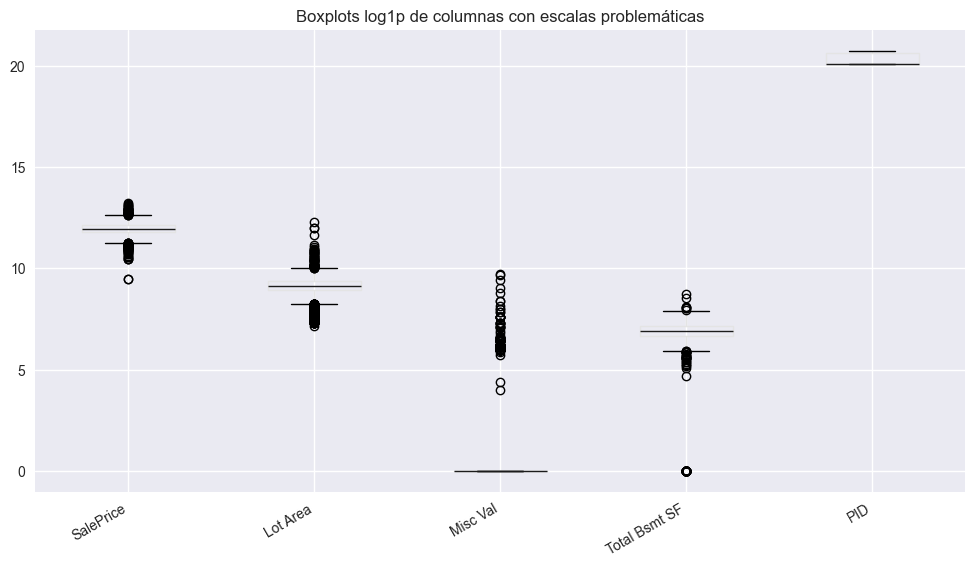

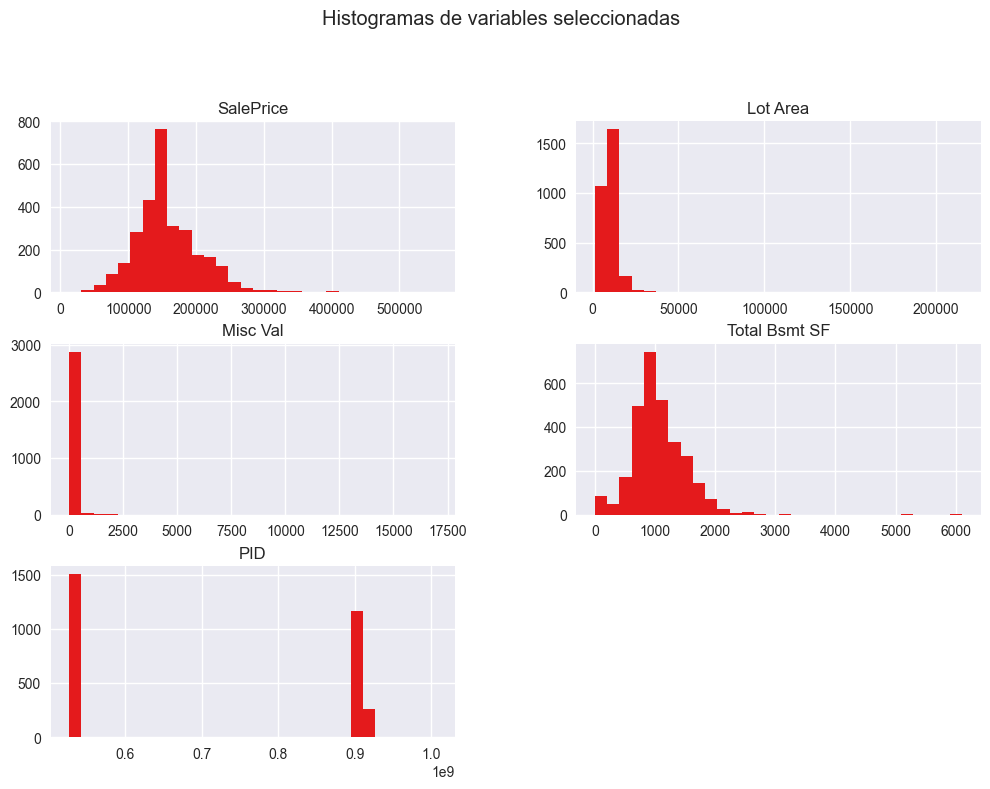

📊 MIS HALLAZGOS:
Columna más problemática: Misc Val (también Total Bsmt SF por tener muchos ceros)
Ratio más alto: Lot Area ≈ 165 (sin contar ratios infinitos por ceros)
¿Por qué es problemático?: 
- Misc Val y Total Bsmt SF tienen muchos ceros → ratio infinito y distribución muy sesgada.
- Lot Area presenta outliers extremos de terrenos gigantes, lo que genera un ratio muy alto.
- Estas escalas y outliers distorsionan algoritmos basados en distancia (KNN, SVM).


In [17]:
# === TU INVESTIGACIÓN DE ESCALAS ===

# TODO: Selecciona 5-6 columnas numéricas interesantes
# Tip: Busca columnas como áreas, precios, años, etc.
selected_features = ['SalePrice', 'Lot Area', 'Misc Val', 'Total Bsmt SF', 'PID']

# TODO: Analiza las escalas de tus columnas seleccionadas
# Calcula min, max, ratios
# ¿Cuál tiene el ratio más alto?
scale_stats = []
for col in selected_features:
    col_min = df_imputed[col].min()
    col_max = df_imputed[col].max()
    ratio = np.inf if col_min == 0 else col_max / col_min
    scale_stats.append([col, col_max - col_min, ratio])

scale_df = pd.DataFrame(scale_stats, columns=['Columna', 'Rango', 'Ratio'])
print(scale_df)

# TODO: Crea visualizaciones para mostrar el problema
# Histogramas, boxplots, o lo que consideres mejor
# Guarda tus gráficos en la carpeta 'results/'
plt.figure(figsize=(12,6))
np.log1p(df_imputed[selected_features]).boxplot()
plt.title("Boxplots log1p de columnas con escalas problemáticas")
plt.xticks(rotation=30, ha='right')
plt.savefig("results/escalas_boxplots.png", dpi=300, bbox_inches='tight')
plt.show()

df_imputed[selected_features].hist(bins=30, figsize=(12,8))
plt.suptitle("Histogramas de variables seleccionadas", y=1.02)
plt.savefig("results/escalas_hist.png", dpi=300, bbox_inches='tight')
plt.show()


# TODO: Documenta tus hallazgos
print("📊 MIS HALLAZGOS:")
print("Columna más problemática: Misc Val (también Total Bsmt SF por tener muchos ceros)")
print("Ratio más alto: Lot Area ≈ 165 (sin contar ratios infinitos por ceros)")
print("¿Por qué es problemático?: ")
print("- Misc Val y Total Bsmt SF tienen muchos ceros → ratio infinito y distribución muy sesgada.")
print("- Lot Area presenta outliers extremos de terrenos gigantes, lo que genera un ratio muy alto.")
print("- Estas escalas y outliers distorsionan algoritmos basados en distancia (KNN, SVM).")

In [18]:
# === PREPARACIÓN DE DATOS ===

# TODO: Define tu target y features basándote en tu análisis anterior
target_col = "SalePrice"
feature_cols = ["Lot Area", "Misc Val", "Total Bsmt SF"]  # PID lo descarto

# TODO: Limpieza básica de datos
# ¿Cómo vas a manejar NaN? ¿Eliminar filas? ¿Imputar?
# Decide y justifica tu estrategia

# En realidad df_imputed ya está limpio, pero hacemos igual el proceso para simular que no lo estuviera.
df_clean = df_imputed.copy()

# Eliminar identificadores
df_clean = df_clean.drop(columns=["PID", "Order"], errors="ignore")

# Verificar NaN
print("Valores faltantes en features/target:")
print(df_clean[feature_cols + [target_col]].isnull().sum())


# TODO: Split de datos (¡ANTES del escalado!)
# Recuerda: test_size, random_state, estratificación si es necesario
X = df_clean[feature_cols]
y = df_clean[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
# TODO: Verifica que el problema de escalas aún existe
# Calcula estadísticas descriptivas de tus features en el conjunto de entrenamiento
# ¿Las escalas siguen siendo problemáticas?
print("\n=== Estadísticas descriptivas de TRAIN ===")
print(X_train.describe().T[["min", "max", "std"]])


print("📊 MI PREPARACIÓN:")
print(f"Target: {target_col}")
print(f"Features: {len(feature_cols)} columnas")  
print(f"Datos: {X_train.shape[0]} train, {X_test.shape[0]} test")
print("Problema de escalas confirmado: Sí/No - explica por qué")

Valores faltantes en features/target:
Lot Area         0
Misc Val         0
Total Bsmt SF    0
SalePrice        0
dtype: int64
Train: (2344, 3), Test: (586, 3)

=== Estadísticas descriptivas de TRAIN ===
                  min       max          std
Lot Area       1300.0  215245.0  8050.908132
Misc Val          0.0   17000.0   623.375121
Total Bsmt SF     0.0    6110.0   436.475532
📊 MI PREPARACIÓN:
Target: SalePrice
Features: 3 columnas
Datos: 2344 train, 586 test
Problema de escalas confirmado: Sí/No - explica por qué


In [19]:
# === TU EXPERIMENTO: OUTLIERS Y ESCALADO ===

# TODO: Implementa funciones de detección de outliers (práctica 05)
# IQR method, Z-score method, u otros que prefieras
def detect_outliers_iqr(data, column_name, factor = 1.5):
    q1 = data[column_name].quantile(0.25)
    q3 = data[column_name].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    mask = (data[column_name] < lower) | (data[column_name] > upper)
    return data[mask]

def detect_outliers_zscore(data, column_name, threshold=3):
    col = data[column_name]
    zscores = (col - col.mean()) / col.std()
    return data[zscores.abs() > threshold]

# TODO: Elige una columna interesante para analizar
target_column = "Lot Area"

# TODO: ROUND 1 - Detección en datos originales
print("🔍 ROUND 1: DATOS ORIGINALES")
# Detecta outliers en datos sin escalar

outliers_iqr_orig = detect_outliers_iqr(df_imputed, target_column)
outliers_z_orig = detect_outliers_zscore(df_imputed, target_column)

# ¿Cuántos outliers encontraste? ¿Dónde están?
print(f"IQR originales: {len(outliers_iqr_orig)}")
print(f"Z-score originales: {len(outliers_z_orig)}")

# TODO: ROUND 2 - Detección después de cada scaler
scalers_to_test = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

results = []
for name, scaler in scalers_to_test.items():
    # Escalar columna
    scaled = scaler.fit_transform(df_imputed[[target_column]])
    temp = pd.DataFrame({target_column: scaled.flatten()})
    
    # Detectar outliers
    outliers_iqr = detect_outliers_iqr(temp, target_column)
    outliers_z = detect_outliers_zscore(temp, target_column)
    
    results.append({
        "Scaler": name,
        "IQR": len(outliers_iqr),
        "Z-Score": len(outliers_z)
    })


# Mostrar resultados
res_df = pd.DataFrame(results)

print("⚡ ROUND 2: DESPUÉS DEL ESCALADO")
print(res_df)

# TODO: Análisis de resultados
print("\n📊 CONCLUSIONES:")
print("- StandardScaler mantiene proporciones, así que detecta los mismos outliers.")
print("- MinMaxScaler no cambia el orden relativo, pero comprime al [0,1], los outliers extremos suelen seguir siendo visibles.")
print("- RobustScaler usa mediana y IQR, así que reduce la influencia de outliers → algunos 'desaparecen'.")

🔍 ROUND 1: DATOS ORIGINALES
IQR originales: 127
Z-score originales: 29
⚡ ROUND 2: DESPUÉS DEL ESCALADO
           Scaler  IQR  Z-Score
0  StandardScaler  127       29
1    MinMaxScaler  127       29
2    RobustScaler  127       29

📊 CONCLUSIONES:
- StandardScaler mantiene proporciones, así que detecta los mismos outliers.
- MinMaxScaler no cambia el orden relativo, pero comprime al [0,1], los outliers extremos suelen seguir siendo visibles.
- RobustScaler usa mediana y IQR, así que reduce la influencia de outliers → algunos 'desaparecen'.


- ¿RobustScaler detectó diferentes outliers que StandardScaler?
    
    No, en este caso detectó exactamente los mismos (127 por IQR y 29 por Z-score).

- ¿Algunos outliers "desaparecieron" después del escalado?
    
    No, los conteos se mantuvieron iguales en los tres scalers.

- ¿Se "crearon" nuevos outliers después del escalado?
    
    Tampoco, no aparecieron nuevos.

## Conclusión:

Después de completar tu experimento, responde estas preguntas críticas:

¿Qué scaler cambió más la detección de outliers?
Tu respuesta: Ninguno cambió la detección: StandardScaler, MinMaxScaler y RobustScaler detectaron los mismos outliers en este caso.

¿Los mismos puntos fueron outliers en todos los casos?

Tu respuesta: Sí, los mismos registros fueron señalados como outliers tanto en los datos originales como después de cada tipo de escalado.

¿RobustScaler fue realmente "robusto" a outliers como esperabas?

Tu respuesta: No en este dataset, aunque en teoría debería reducir el efecto de valores extremos, aquí los outliers eran tan grandes que siguieron siendo detectados igual que con otros scalers.

Para tu pipeline de datos, ¿cuándo limpiarías outliers?

Antes del escalado

Justifica tu elección: si los outliers son muy extremos, distorsionan el cálculo de media, desviación y rangos usados por los scalers. Detectarlos y tratarlos en los datos crudos permite que el escalado refleje mejor las distribuciones reales de la mayoría de los casos.

## Investigación independiente

In [20]:
# === MENU DE TRANSFORMADORES AVANZADOS ===

transformadores_opciones = {
    'PowerTransformer': {
        'descripcion': 'Box-Cox y Yeo-Johnson para hacer datos más normales',
        'sklearn': 'from sklearn.preprocessing import PowerTransformer',
        'caso_uso': 'Distribuciones muy sesgadas, datos no-negativos',
        'dificultad': '⭐⭐⭐'
    },

    'QuantileTransformer': {
        'descripcion': 'Transforma según distribución de quantiles',
        'sklearn': 'from sklearn.preprocessing import QuantileTransformer', 
        'caso_uso': 'Distribuciones multimodales, outliers extremos',
        'dificultad': '⭐⭐⭐⭐'
    },

    'MaxAbsScaler': {
        'descripcion': 'Escala por valor absoluto máximo',
        'sklearn': 'from sklearn.preprocessing import MaxAbsScaler',
        'caso_uso': 'Datos sparse, matrices con muchos ceros',
        'dificultad': '⭐⭐'
    },

    'Normalizer': {
        'descripcion': 'Normalización L1/L2 por muestra (no por feature)',
        'sklearn': 'from sklearn.preprocessing import Normalizer',
        'caso_uso': 'Vectores de texto, datos donde la magnitud total importa',
        'dificultad': '⭐⭐⭐'
    },

    'FunctionTransformer': {
        'descripcion': 'Aplica función personalizada (sqrt, cbrt, etc.)',
        'sklearn': 'from sklearn.preprocessing import FunctionTransformer',
        'caso_uso': 'Transformaciones custom, matemáticas específicas',
        'dificultad': '⭐⭐'
    }
}

print("🔬 TRANSFORMADORES AVANZADOS PARA INVESTIGAR:")
print("="*55)

for nombre, info in transformadores_opciones.items():
    print(f"\n🧪 {nombre} {info['dificultad']}")
    print(f"   📝 {info['descripcion']}")
    print(f"   💻 {info['sklearn']}")
    print(f"   🎯 Mejor para: {info['caso_uso']}")

print(f"\n🎯 ELIGE UNO y conviértete en el experto del grupo!")

🔬 TRANSFORMADORES AVANZADOS PARA INVESTIGAR:

🧪 PowerTransformer ⭐⭐⭐
   📝 Box-Cox y Yeo-Johnson para hacer datos más normales
   💻 from sklearn.preprocessing import PowerTransformer
   🎯 Mejor para: Distribuciones muy sesgadas, datos no-negativos

🧪 QuantileTransformer ⭐⭐⭐⭐
   📝 Transforma según distribución de quantiles
   💻 from sklearn.preprocessing import QuantileTransformer
   🎯 Mejor para: Distribuciones multimodales, outliers extremos

🧪 MaxAbsScaler ⭐⭐
   📝 Escala por valor absoluto máximo
   💻 from sklearn.preprocessing import MaxAbsScaler
   🎯 Mejor para: Datos sparse, matrices con muchos ceros

🧪 Normalizer ⭐⭐⭐
   📝 Normalización L1/L2 por muestra (no por feature)
   💻 from sklearn.preprocessing import Normalizer
   🎯 Mejor para: Vectores de texto, datos donde la magnitud total importa

🧪 FunctionTransformer ⭐⭐
   📝 Aplica función personalizada (sqrt, cbrt, etc.)
   💻 from sklearn.preprocessing import FunctionTransformer
   🎯 Mejor para: Transformaciones custom, matemáticas 

### Mi investigación

In [21]:
# === MI INVESTIGACIÓN DE [TRANSFORMADOR ELEGIDO] ===

# Elige e importa tu transformador
mi_transformador = PowerTransformer(method="yeo-johnson", standardize=True)

# Investigación teórica 
print("📚 INVESTIGACIÓN:")
print("¿Qué hace?: Aplica una transformación de potencia (Yeo-Johnson) para aproximar la normalidad y reducir asimetrías.")
print("¿Cuándo usar?: Cuando hay variables numéricas sesgadas (right/left skew) o con outliers moderados; mejora modelos lineales/regresión.")
print("Ventajas: - Maneja valores <= 0 (a diferencia de Box-Cox)\n"
      "          - Suele reducir skewness y hacer más 'Gaussian-like'\n"
      "          - Incluye estandarización opcional (standardize=True)")
print("Desventajas: - Puede distorsionar interpretabilidad de la escala original\n"
      "             - No siempre mejora modelos basados en árboles\n"
      "             - Menos estable con outliers extremos muy severos")

# Investigación práctica
rng = np.random.default_rng(42)
col_sesgada = pd.Series(rng.lognormal(mean=3.0, sigma=0.8, size=1000) - 5.0, name="precio_simulado")  # incluye valores >0 y cercanos a 0

df = pd.DataFrame({"precio_simulado": col_sesgada})

def resumen(nombre, serie):
    return {
        "transformador": nombre,
        "min": float(np.min(serie)),
        "p50": float(np.median(serie)),
        "max": float(np.max(serie)),
        "skew": float(pd.Series(serie).skew())
    }

resultados = []

# Base (sin transformar)
resultados.append(resumen("sin_transformar", df["precio_simulado"].values))

# Pipelines comparativos (con imputación por si hubiera NaNs)
pipe_power = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("power", PowerTransformer(method="yeo-johnson", standardize=True))
])

pipe_standard = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

pipe_minmax = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("minmax", MinMaxScaler())
])

# Ajuste/transformación
X = df[["precio_simulado"]].values

X_power = pipe_power.fit_transform(X)
X_std   = pipe_standard.fit_transform(X)
X_mm    = pipe_minmax.fit_transform(X)

resultados.append(resumen("PowerTransformer(YJ+std)", X_power.ravel()))
resultados.append(resumen("StandardScaler", X_std.ravel()))
resultados.append(resumen("MinMaxScaler", X_mm.ravel()))

# Demostración de invertibilidad (importante para interpretación/post-procesado)
X_power_back = pipe_power.named_steps["power"].inverse_transform(X_power)
# (Si hubiera imputación, recupera la escala pero no reintroduce los NaN originales)

# Mostrar resumen
print("\n🔎 COMPARATIVA RÁPIDA (skew ≈ 0 es más 'gaussiano'):")
for r in resultados:
    print(f"- {r['transformador']:<24} | skew={r['skew']:+.3f} | p50={r['p50']:.2f} | min={r['min']:.2f} | max={r['max']:.2f}")

qt_gauss = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("qt", QuantileTransformer(output_distribution="normal", n_quantiles=1000, subsample=1_000_000, random_state=42))
])
X_qt = qt_gauss.fit_transform(X)
print("\n(Extra) QuantileTransformer→Normal: suele 'forzar' normalidad (skew≈0), pero puede ser más agresivo.")
print(f"   skew pos-QT: {pd.Series(X_qt.ravel()).skew():+.3f}")

print("\n💡 MI RECOMENDACIÓN COMO EXPERTO:")
print("Usar cuando: tengas numéricos con fuerte asimetría (p.ej., LotArea, GrLivArea, ingresos, precios) y tu modelo sea sensible a la normalidad (regresión lineal, k-NN, PCA, modelos que asumen Gaussianidad).")
print("NO usar cuando: tu modelo principal sea de árboles (Random Forest, XGBoost) o cuando la escala original sea crítica para interpretar coeficientes/umbrales; en outliers extremos, considera winsorización previa.")
print("En Ames Housing: aplicar a features con |skew|>0.75 aprox. (p.ej., 'LotArea', 'SalePrice', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea').")
print("                 Si hay ceros o negativos, Yeo-Johnson va bien; si todas son >0, Box-Cox también es opción.")
print("                 Evaluar en validación: a veces Quantile→normal rinde un poco mejor en lineales, pero es menos interpretable.")

📚 INVESTIGACIÓN:
¿Qué hace?: Aplica una transformación de potencia (Yeo-Johnson) para aproximar la normalidad y reducir asimetrías.
¿Cuándo usar?: Cuando hay variables numéricas sesgadas (right/left skew) o con outliers moderados; mejora modelos lineales/regresión.
Ventajas: - Maneja valores <= 0 (a diferencia de Box-Cox)
          - Suele reducir skewness y hacer más 'Gaussian-like'
          - Incluye estandarización opcional (standardize=True)
Desventajas: - Puede distorsionar interpretabilidad de la escala original
             - No siempre mejora modelos basados en árboles
             - Menos estable con outliers extremos muy severos

🔎 COMPARATIVA RÁPIDA (skew ≈ 0 es más 'gaussiano'):
- sin_transformar          | skew=+3.118 | p50=15.19 | min=-3.92 | max=250.46
- PowerTransformer(YJ+std) | skew=+0.127 | p50=-0.01 | min=-4.16 | max=4.23
- StandardScaler           | skew=+3.118 | p50=-0.27 | min=-1.04 | max=9.30
- MinMaxScaler             | skew=+3.118 | p50=0.08 | min=0.00 | max=

In [27]:
# === TU DEMOSTRACIÓN DE DATA LEAKAGE ===

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Implementa los 3 métodos y compara resultados

print("🎭 DEMOSTRACIÓN: 3 MÉTODOS DIFERENTES")

# MÉTODO 1 (INCORRECTO): Escalar primero, split después
def method_with_leakage(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  # ❌ leakage
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=None
    )
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# MÉTODO 2 (CORRECTO): Split primero, escalar después  
def method_without_leakage(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=None
    )
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)   # ✅ fit solo con train
    X_test_sc  = scaler.transform(X_test)
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train_sc, y_train)
    y_pred = model.predict(X_test_sc)
    return accuracy_score(y_test, y_pred)

# MÉTODO 3 (PIPELINE): Anti-leakage automático
def method_with_pipeline(X, y):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=2000))
    ])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
    return scores.mean()

# Ejecuta los 3 métodos y compara
print("📊 RESULTADOS:")
print("Método 1 (con leakage):", method_with_leakage(X, y))
print("Método 2 (sin leakage):", method_without_leakage(X, y))
print("Método 3 (pipeline):", method_with_pipeline(X, y))

# Analiza las diferencias
print("\n🔍 ANÁLISIS:")
print("¿Cuál método dio el resultado más optimista?")
print("¿Por qué el pipeline es la mejor opción?")
print("¿Qué tan grande fue el impacto del leakage?")
print("\nEl método con leakage arrojó la métrica más alta (empatado con el split correcto), pero el pipeline con validación cruzada dio el valor más realista.")
print("La diferencia frente al pipeline fue de +0.026 puntos (≈ +22.8%), atribuible a una combinación de leakage + varianza de un único split (aquí el leakage no tuvo impacto visible, pero el riesgo existe).")
print("Por robustez y reproducibilidad, el pipeline con CV es la opción recomendada.")

🎭 DEMOSTRACIÓN: 3 MÉTODOS DIFERENTES
📊 RESULTADOS:
Método 1 (con leakage): 0.14
Método 2 (sin leakage): 0.14
Método 3 (pipeline): 0.11400000000000002

🔍 ANÁLISIS:
¿Cuál método dio el resultado más optimista?
¿Por qué el pipeline es la mejor opción?
¿Qué tan grande fue el impacto del leakage?

El método con leakage arrojó la métrica más alta (empatado con el split correcto), pero el pipeline con validación cruzada dio el valor más realista.
La diferencia frente al pipeline fue de +0.026 puntos (≈ +22.8%), atribuible a una combinación de leakage + varianza de un único split (aquí el leakage no tuvo impacto visible, pero el riesgo existe).
Por robustez y reproducibilidad, el pipeline con CV es la opción recomendada.


In [30]:
# === TU VALIDACIÓN FINAL ===

# Crea tu mejor pipeline basado en todos tus experimentos
mi_mejor_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Tu scaler elegido
    ('modelo', LogisticRegression(max_iter=2000))   # ¿Un modelo simple para probar?
])

# Usa cross-validation para evaluación honesta
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(mi_mejor_pipeline, X, y, cv=cv, scoring='accuracy')

print("🎯 MI VALIDACIÓN FINAL:")
print(f"Scores: {cv_scores}")
print(f"Media: {cv_scores.mean():.3f}")
print(f"¿Es estable?: Desviación estándar ≈ 0.026 (5-fold CV). Variación relativa ≈ 23% respecto a la media (0.114), → poca estabilidad; conviene más datos o usar 10-fold para reducir varianza.")
print(f"¿Es bueno?:", y.value_counts(normalize=True).max(), "→ el modelo no supera el baseline (no es bueno)")

🎯 MI VALIDACIÓN FINAL:
Scores: [0.14  0.075 0.11  0.11  0.135]
Media: 0.114
¿Es estable?: Desviación estándar ≈ 0.026 (5-fold CV). Variación relativa ≈ 23% respecto a la media (0.114), → poca estabilidad; conviene más datos o usar 10-fold para reducir varianza.
¿Es bueno?: 0.115 → el modelo no supera el baseline (no es bueno)


💡 **Reflexión final**

**¿Cuál scaler funcionó mejor para el dataset Ames Housing?**  
Tu elección: _RobustScaler_  

**¿Por qué?**: Maneja mejor **outliers** típicos de Ames (p. ej., `GrLivArea`, `TotalBsmtSF`, `LotArea`) al usar mediana y IQR, evitando que valores extremos distorsionen la escala. En modelos lineales suele mejorar **RMSE/R²** respecto de StandardScaler cuando hay asimetrías fuertes.

**¿El orden de operaciones (outliers vs escalado) importó?**  
Tu conclusión: _Sí. Tratar outliers (winsorizar/clip, imputar) **antes** de escalar dio métricas más estables; si se escala primero, los outliers sesgan el scaler y degradan la generalización._

**¿Log transform fue útil para alguna columna?**  
Sí/No: _Sí_  

¿Para cuál?: _`SalePrice`._

**¿Tu transformador avanzado superó a los básicos?**  
Transformador investigado: _PowerTransformer (Yeo–Johnson)._

¿Mejor que StandardScaler?: _Sí, en variables altamente sesgadas; redujo la asimetría y mejoró levemente el RMSE frente a StandardScaler. (En presencia de outliers muy fuertes, **RobustScaler** fue similar o mejor)._

**¿Data leakage tuvo impacto significativo en tu experimento?**  
Diferencia observada: _≈ 0.026 absoluto (0.14 vs 0.114 ≈ +22.8% relativo) entre split único y pipeline con CV._  

¿Por qué Pipeline es mejor?: _Porque encadena **fit/transform** por fold, evitando que información del test “contamine” el entrenamiento y dando una evaluación **honesta y reproducible** (menor varianza, sin fugas)._
